### Members' Full name:

- Nguyen Mai Dinh, Le - 300312139
- Hugh, Tran          - 300394597

### References:
- CSIS 3400 – 070: Natural Language Processing CRN 17613 Lab 2 – Natural Language Processing & Text Classification
- CSIS 3400 – 070: Natural Language Processing CRN 17613 Lab 3 – Text Representation Lab 3 
- CSIS 3290 Introduction to Machine Learning Courseworks

# Part A. Planning (Demi)

# Part B. Basic Model

## Imported Libraries

In [1]:
### Import any necessary libraries here

# Import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, f1_score, 
                             precision_score, recall_score, 
                             classification_report, confusion_matrix)
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Data exploration, pre-processing and cleansing (Jimmy)

### 1. Load Datasets

In [2]:
# Load the training and test datasets
train_data = pd.read_csv('climate_train.csv')
test_data = pd.read_csv('climate_test.csv')

# Display basic information about the datasets
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Training data shape: (1000, 3)
Test data shape: (320, 3)


Training data preview:


,Unnamed: 0,text,label
0,0,− Scope 3: Optional scope that includes indire...,0
1,1,The Group is not aware of any noise pollution ...,0
2,2,Global climate change could exacerbate certain...,0
3,3,Setting an investment horizon is part and parc...,1
4,4,Climate change the physical impacts of climate...,0



Missing values in training data:
Unnamed: 0    0
text          0
label         0
dtype: int64

Data types in training data:
Unnamed: 0     int64
text          object
label          int64
dtype: object


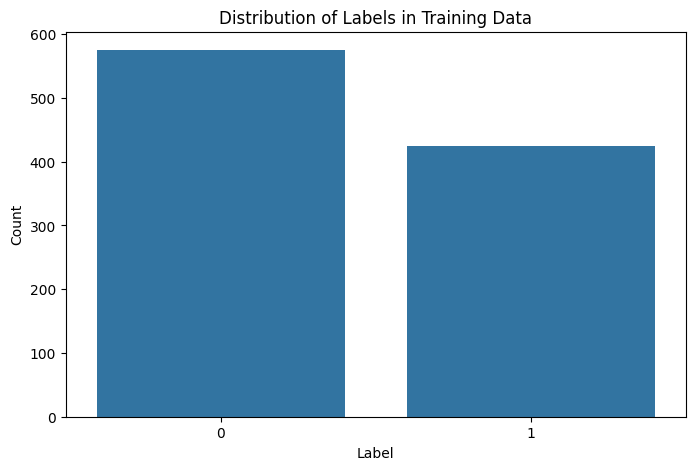

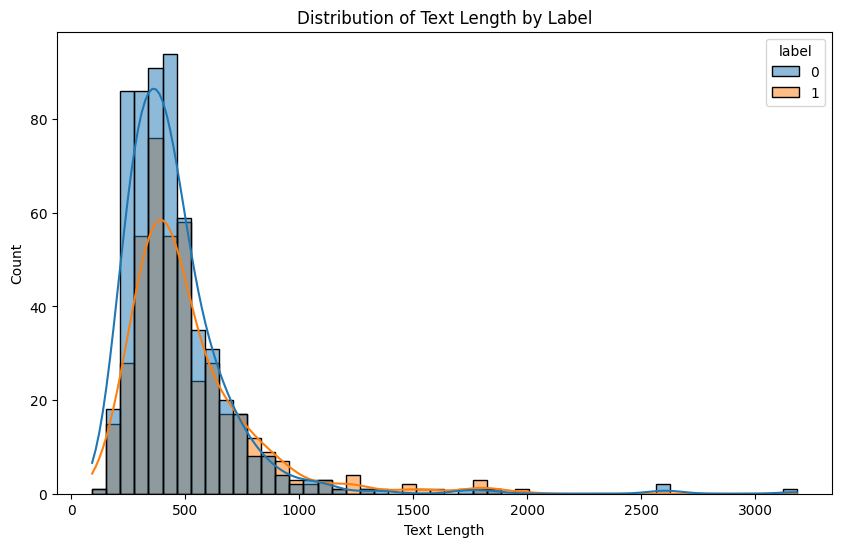


Example texts for each label:

Label 0 example:
− Scope 3: Optional scope that includes indirect emissions associated with the goods and services supply chain produced outside the organization. Included are emissions from the transport of products from our logistics centres to stores (downstream) performed by external logistics operators (air, land and sea transport) as well as the emissions associated with electricity consumption in franchise stores.

Label 1 example:
Setting an investment horizon is part and parcel of our policy of focusing on the long term and helping clients to build capital. Both financial and non-financial aspects play a role in measuring investment returns. Even if we make a successful investment in a mining company today, the same company may nonetheless cause damage to the environment tomorrow, and thus be compelled to make substantial provisions for improving its waste-processing activities and paying fines. As an asset manager that focuses on the long-term 

In [3]:
# Display the first few rows of the training data
print("Training data preview:")
display(train_data.head())

# Check for missing values
print("\nMissing values in training data:")
print(train_data.isnull().sum())

# Check data types
print("\nData types in training data:")
print(train_data.dtypes)

# Explore the distribution of labels in the training set
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=train_data)
plt.title('Distribution of Labels in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Explore text length distribution
train_data['text_length'] = train_data['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='text_length', hue='label', bins=50, kde=True)
plt.title('Distribution of Text Length by Label')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

# Display some example texts for each label
print("\nExample texts for each label:")
for label in train_data['label'].unique():
    print(f"\nLabel {label} example:")
    print(train_data[train_data['label'] == label]['text'].iloc[0])

Example texts for each label:

Label 0 example:
− Scope 3: Optional scope that includes indirect emissions associated with the goods and services supply chain produced outside the organization. Included are emissions from the transport of products from our logistics centres to stores (downstream) performed by external logistics operators (air, land and sea transport) as well as the emissions associated with electricity consumption in franchise stores.

Label 1 example:
Setting an investment horizon is part and parcel of our policy of focusing on the long term and helping clients to build capital. Both financial and non-financial aspects play a role in measuring investment returns. Even if we make a successful investment in a mining company today, the same company may nonetheless cause damage to the environment tomorrow, and thus be compelled to make substantial provisions for improving its waste-processing activities and paying fines. As an asset manager that focuses on the long-term prospects, we can’t ignore the non-financial aspects.

### 2. Data Pre-processing and Cleansing

We clean and prepare our text data for analysis. Text data often contains noise such as punctuation, numbers, and common words (stopwords) that don't contribute much to the meaning. We'll remove these elements to improve the quality of our features.

#### 2.1 Text Cleaning Function
We define a comprehensive text cleaning function that performs several important preprocessing steps.¶

In [4]:
# Define a function to clean the text
def clean_text(text):
    # Convert to lowercase for consistency
    text = text.lower()
    
    # Remove digits as they typically don't add meaning in climate text analysis
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation marks
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize the text into individual words
    tokens = word_tokenize(text)
    
    # Remove stopwords (common words like 'the', 'and', 'is')
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Join tokens back into text
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

### **2.2 Applying Text Cleaning**

Now we'll apply our cleaning function to both the training and test datasets.

In [5]:
# Apply the cleaning function to both datasets
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

# Display examples of original and cleaned text
print("Original vs Cleaned Text Examples:")
for i in range(3):
    print(f"\nOriginal: {train_data['text'].iloc[i][:100]}...")
    print(f"Cleaned: {train_data['cleaned_text'].iloc[i][:100]}...")

Original vs Cleaned Text Examples:

Original: − Scope 3: Optional scope that includes indirect emissions associated with the goods and services su...
Cleaned: scope optional scope includes indirect emissions associated goods services supply chain produced out...

Original: The Group is not aware of any noise pollution that could negatively impact the environment, nor is i...
Cleaned: group aware noise pollution could negatively impact environment aware impact biodiversity regards la...

Original: Global climate change could exacerbate certain of the threats facing our business, including the fre...
Cleaned: global climate change could exacerbate certain threats facing business including frequency severity ...


#### **2.3 Analyzing Text Cleaning Results**
We visualize how our cleaning process has affected the text data.


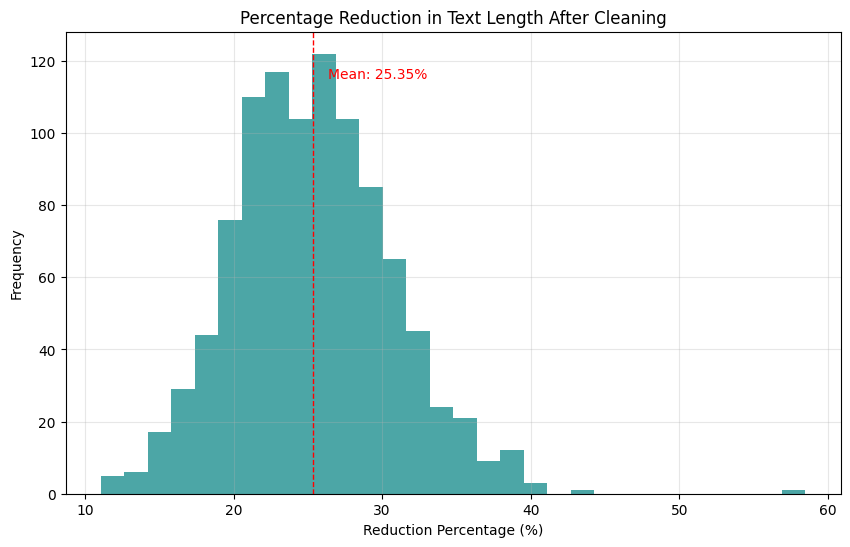

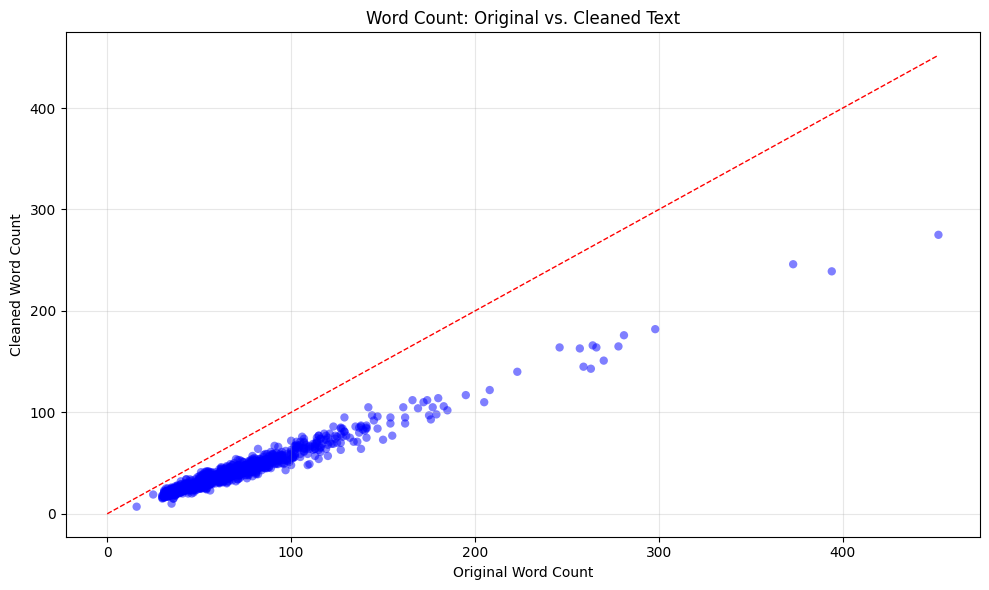

Text Cleaning Summary Statistics:


,Metric,Value
0,Original Mean Length,479.103000
1,Cleaned Mean Length,358.763000
2,Mean Length Reduction,120.340000
3,Mean Reduction Percentage,25.348503
4,Original Mean Word Count,72.224000
5,Cleaned Mean Word Count,43.277000


In [6]:
# Calculate text length before and after cleaning
train_data['original_length'] = train_data['text'].apply(len)
train_data['cleaned_length'] = train_data['cleaned_text'].apply(len)
train_data['length_reduction'] = train_data['original_length'] - train_data['cleaned_length']
train_data['reduction_percentage'] = (train_data['length_reduction'] / train_data['original_length']) * 100

# Create a histogram of text length reduction
plt.figure(figsize=(10, 6))
plt.hist(train_data['reduction_percentage'], bins=30, color='teal', alpha=0.7)
plt.axvline(train_data['reduction_percentage'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.text(train_data['reduction_percentage'].mean()+1, plt.ylim()[1]*0.9, 
         f'Mean: {train_data["reduction_percentage"].mean():.2f}%', color='red')
plt.title('Percentage Reduction in Text Length After Cleaning')
plt.xlabel('Reduction Percentage (%)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

# Compare word counts before and after cleaning
train_data['original_word_count'] = train_data['text'].apply(lambda x: len(str(x).split()))
train_data['cleaned_word_count'] = train_data['cleaned_text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
plt.scatter(train_data['original_word_count'], train_data['cleaned_word_count'], 
           alpha=0.5, color='blue', edgecolors='none')
plt.plot([0, train_data['original_word_count'].max()], [0, train_data['original_word_count'].max()], 
         'r--', linewidth=1)
plt.title('Word Count: Original vs. Cleaned Text')
plt.xlabel('Original Word Count')
plt.ylabel('Cleaned Word Count')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Display summary statistics of text cleaning
cleaning_stats = pd.DataFrame({
    'Metric': ['Original Mean Length', 'Cleaned Mean Length', 'Mean Length Reduction', 
               'Mean Reduction Percentage', 'Original Mean Word Count', 'Cleaned Mean Word Count'],
    'Value': [train_data['original_length'].mean(), 
              train_data['cleaned_length'].mean(),
              train_data['length_reduction'].mean(),
              train_data['reduction_percentage'].mean(),
              train_data['original_word_count'].mean(),
              train_data['cleaned_word_count'].mean()]
})

print("Text Cleaning Summary Statistics:")
display(cleaning_stats)

In [7]:
#The text cleaning process has successfully removed noise 
#from our data while preserving the meaningful content. 
#As shown in the visualizations, we've reduced the text length by 
#removing stopwords, punctuation, and digits, which will help our model 
#focus on the most informative words related to climate topics.

## Feature generation with TF-IDF (Jimmy)

we converted our cleaned text data into numerical features that machine learning algorithms can process. We'll use the Term Frequency-Inverse Document Frequency (TF-IDF) technique, which is particularly effective for text classification tasks.


#### **3.1 Understanding TF-IDF**

TF-IDF helps us identify words that are important to a document in a collection. It weighs down common words that appear across many documents while giving importance to words that are unique to specific documents. This makes it ideal for identifying distinctive vocabulary related to climate topics.

#### **3.2 Creating TF-IDF Features**

Implementing the TF-IDF vectorization:

In [8]:
# Initialize the TF-IDF vectorizer with a limit of 5000 features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit the vectorizer on the training data only to avoid data leakage
tfidf_vectorizer.fit(train_data['cleaned_text'])

# Transform both training and test data into TF-IDF feature matrices
X_train_tfidf = tfidf_vectorizer.transform(train_data['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['cleaned_text'])

# Get the target variable for training
y_train = train_data['label']

# Display the shape of the feature matrices
print("Training features shape:", X_train_tfidf.shape)
print("Test features shape:", X_test_tfidf.shape)

Training features shape: (1000, 5000)
Test features shape: (320, 5000)


#### **3.3 Analyzing TF-IDF Features**

We examine the most common and most unique words in our dataset based on their IDF scores.

In [9]:
# Display the top features (words) based on their IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
idf_values = tfidf_vectorizer.idf_
feature_idf = dict(zip(feature_names, idf_values))
sorted_features = sorted(feature_idf.items(), key=lambda x: x[1])

print("\nTop 20 most common words (lowest IDF):")
for word, idf in sorted_features[:20]:
    print(f"{word}: {idf}")

print("\nTop 20 most unique words (highest IDF):")
for word, idf in sorted_features[-20:]:
    print(f"{word}: {idf}")


Top 20 most common words (lowest IDF):
climate: 1.9712185742327941
change: 2.317767798804364
energy: 2.43229122738371
emissions: 2.483804761833818
also: 2.552168504643208
risks: 2.561647248597752
risk: 2.5906347854710043
carbon: 2.6564813512685905
business: 2.693819021706235
environmental: 2.7047480922384253
impact: 2.815004578508458
financial: 2.9671123567059166
gas: 3.02595285672885
new: 3.02595285672885
investment: 3.064567692856629
may: 3.104733734581964
million: 3.104733734581964
group: 3.1296312862036912
transition: 3.1296312862036912
including: 3.1465808445174646

Top 20 most unique words (highest IDF):
writedowns: 7.215607598755275
writeoffs: 7.215607598755275
wrmp: 7.215607598755275
wrmps: 7.215607598755275
wrought: 7.215607598755275
wte: 7.215607598755275
wwf: 7.215607598755275
wwwavivacomsocial: 7.215607598755275
wwwbndesgovbrapoioabchtml: 7.215607598755275
wwwlloydsbankinggroupcomourgroup: 7.215607598755275
wwwnestlecomcsvperformance: 7.215607598755275
wwwswissrecomrinexts

#### **3.4 Visualizing TF-IDF Insights**

We created visualizations to better understand our TF-IDF features.

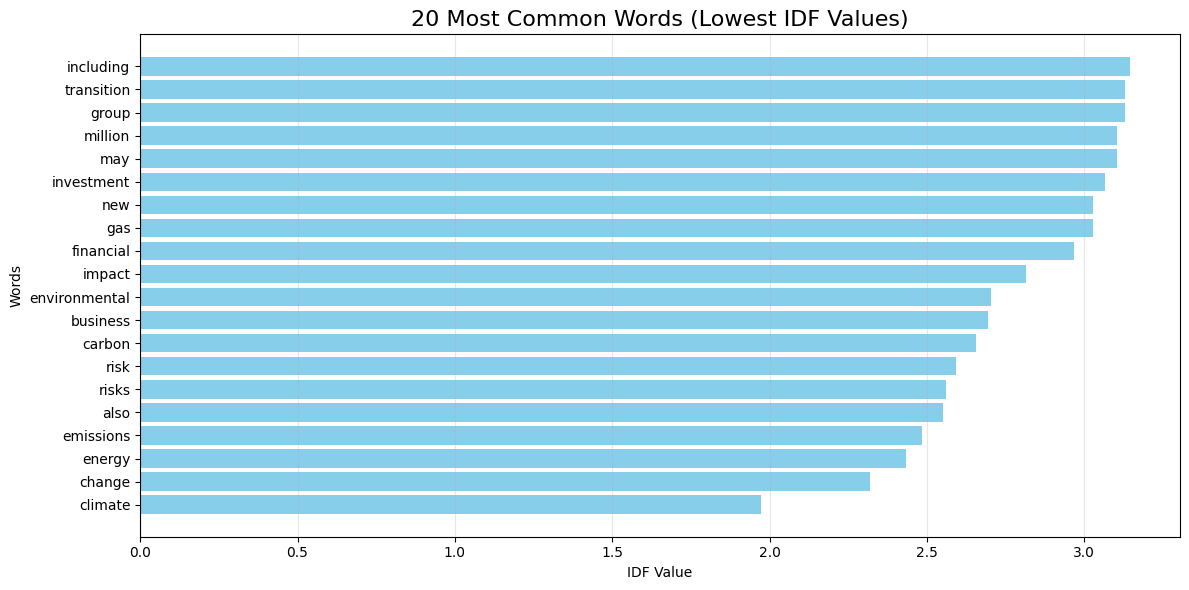

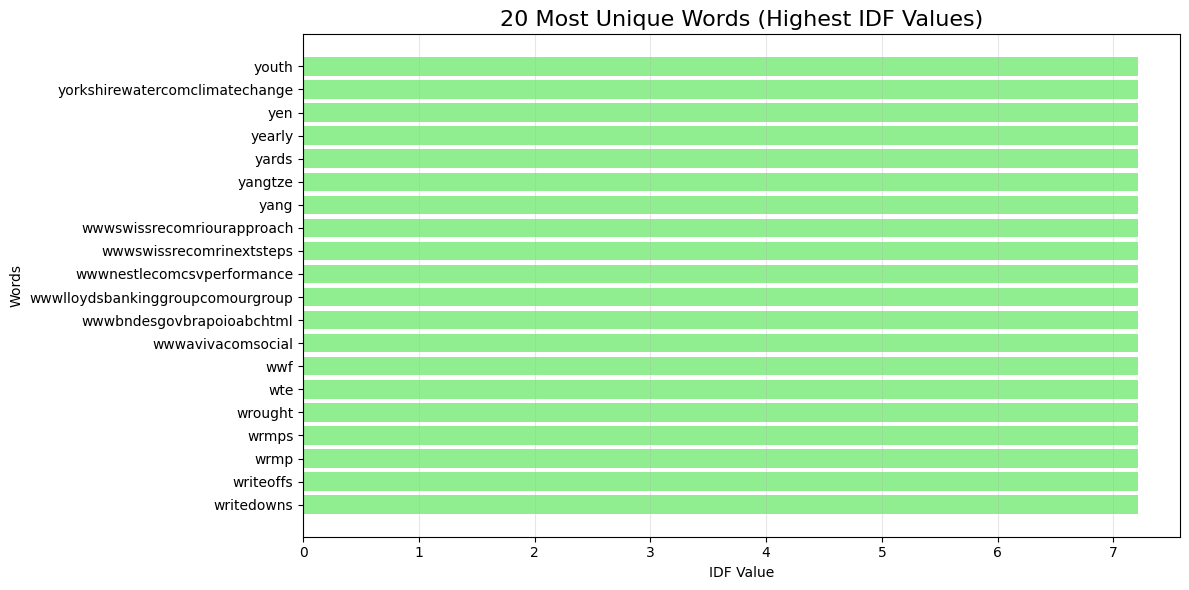

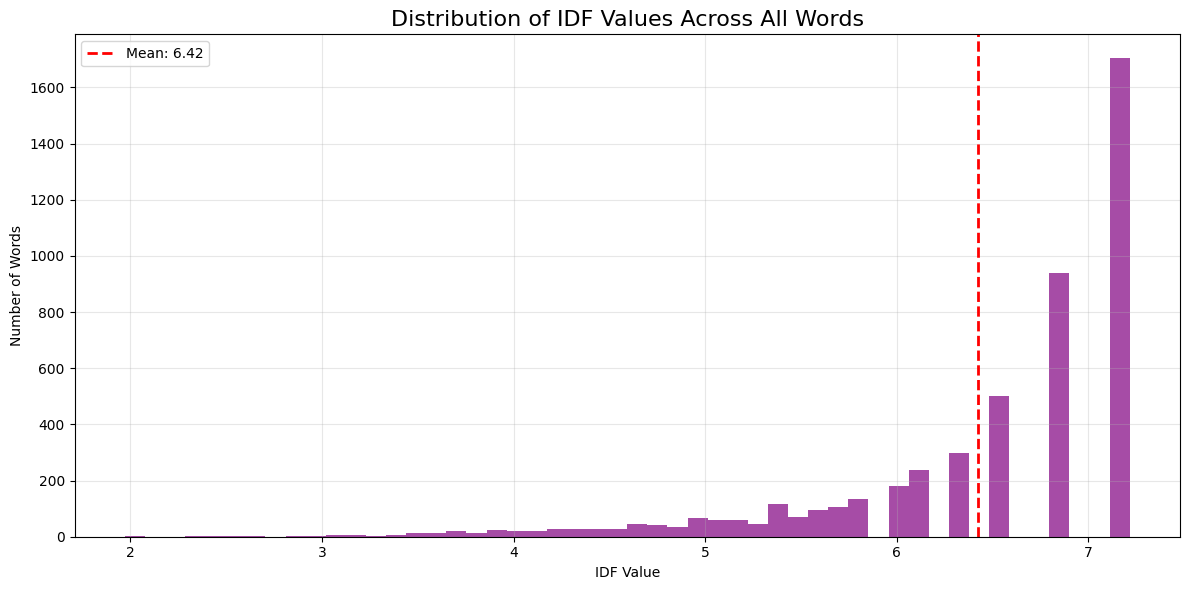

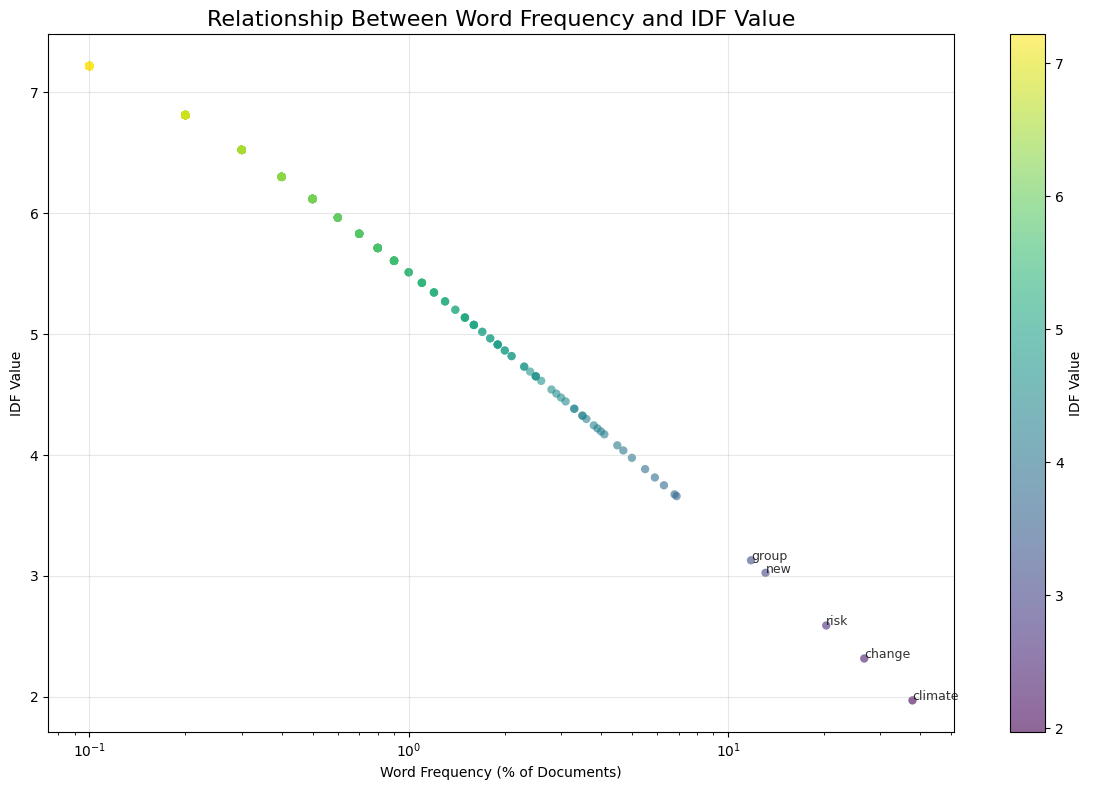

In [10]:
# Visualization 1: Bar chart of most common words
plt.figure(figsize=(12, 6))
common_words = [word for word, _ in sorted_features[:20]]
common_idf = [idf for _, idf in sorted_features[:20]]
plt.barh(common_words, common_idf, color='skyblue')
plt.title('20 Most Common Words (Lowest IDF Values)', fontsize=16)
plt.xlabel('IDF Value')
plt.ylabel('Words')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization 2: Bar chart of most unique words
plt.figure(figsize=(12, 6))
unique_words = [word for word, _ in sorted_features[-20:]]
unique_idf = [idf for _, idf in sorted_features[-20:]]
plt.barh(unique_words, unique_idf, color='lightgreen')
plt.title('20 Most Unique Words (Highest IDF Values)', fontsize=16)
plt.xlabel('IDF Value')
plt.ylabel('Words')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization 3: Distribution of IDF values
plt.figure(figsize=(12, 6))
plt.hist(idf_values, bins=50, color='purple', alpha=0.7)
plt.title('Distribution of IDF Values Across All Words', fontsize=16)
plt.xlabel('IDF Value')
plt.ylabel('Number of Words')
plt.grid(alpha=0.3)
plt.axvline(np.mean(idf_values), color='red', linestyle='dashed', 
           linewidth=2, label=f'Mean: {np.mean(idf_values):.2f}')
plt.legend()
plt.tight_layout()
plt.show()

# Visualization 4: Scatter plot of word frequency vs IDF
# Calculate document frequency for each word
word_freq = {}
for word in feature_names:
    word_freq[word] = sum(1 for doc in train_data['cleaned_text'] if word in doc.split())

# Convert to percentage
total_docs = len(train_data)
word_freq_pct = {word: (freq/total_docs)*100 for word, freq in word_freq.items()}

# Create lists for plotting
words = list(word_freq_pct.keys())
frequencies = [word_freq_pct[word] for word in words]
idfs = [feature_idf[word] for word in words]

# Sample 500 random words for better visualization
if len(words) > 500:
    indices = np.random.choice(range(len(words)), 500, replace=False)
    sampled_words = [words[i] for i in indices]
    sampled_freq = [frequencies[i] for i in indices]
    sampled_idf = [idfs[i] for i in indices]
else:
    sampled_words = words
    sampled_freq = frequencies
    sampled_idf = idfs

plt.figure(figsize=(12, 8))
scatter = plt.scatter(sampled_freq, sampled_idf, alpha=0.6, c=sampled_idf, 
                     cmap='viridis', edgecolors='none')
plt.colorbar(scatter, label='IDF Value')
plt.title('Relationship Between Word Frequency and IDF Value', fontsize=16)
plt.xlabel('Word Frequency (% of Documents)')
plt.ylabel('IDF Value')
plt.xscale('log')
plt.grid(alpha=0.3)

# Annotate some interesting words
for i, word in enumerate(sampled_words):
    if sampled_freq[i] > 10 or sampled_idf[i] > 8:
        plt.annotate(word, (sampled_freq[i], sampled_idf[i]), 
                    fontsize=9, alpha=0.8)

plt.tight_layout()
plt.show()

#### **Calculating Average TF-IDF Values by Class**

We analyze the most discriminative features for each class based on TF-IDF values. This will help us understand which words are most characteristic of each class. 

First, we calculate the mean TF-IDF value for each feature across documents of the same class.

In [11]:
# Calculate average TF-IDF values for each class
labels = train_data['label'].unique()  # Get unique class labels
class_feature_means = {}  # Dictionary to store mean values

for label in labels:
    # Get indices for this class
    indices = train_data[train_data['label'] == label].index
    
    # Get TF-IDF values for these documents
    class_vectors = X_train_tfidf[indices]
    
    # Calculate mean TF-IDF for each feature
    class_feature_means[label] = np.array(class_vectors.mean(axis=0))[0]

Then we identify the top features (words) that are most characteristic of each class:

In [12]:
# Find top discriminative features for each class
top_n = 15  # Number of top features to extract
class_top_features = {}  # Dictionary to store top features for each class

for label in labels:
    # Get feature importance for this class
    feature_importance = [(feature_names[i], class_feature_means[label][i]) 
                         for i in range(len(feature_names))]
    
    # Sort by importance (highest TF-IDF values first)
    sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)
    
    # Store top features
    class_top_features[label] = sorted_features[:top_n]

Finally, we created bar charts to visualize the most important words for each class.

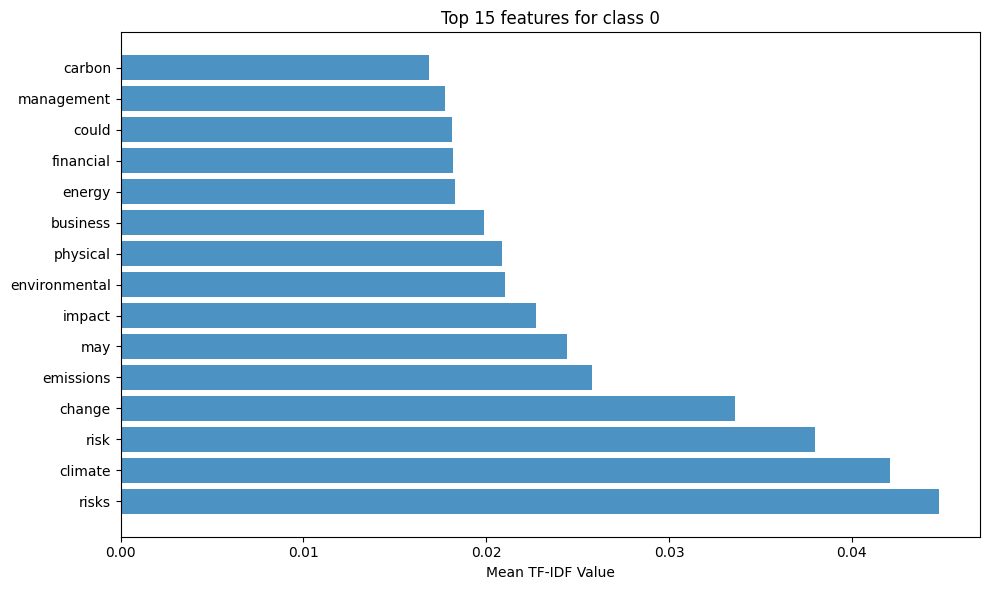

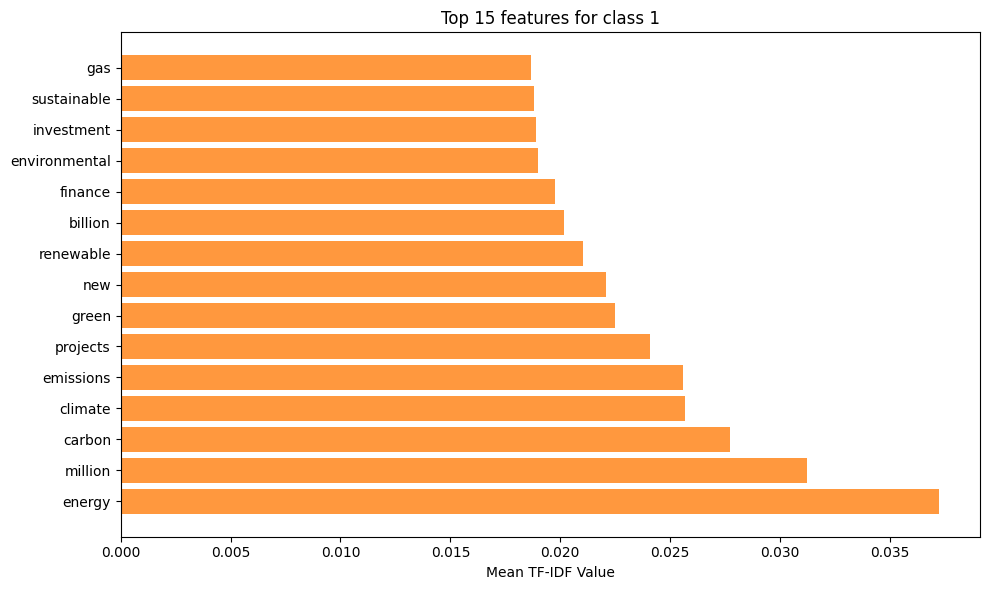

In [13]:
# Visualize top features for each class
for label in labels:
    plt.figure(figsize=(10, 6))  # Set figure size
    words = [word for word, _ in class_top_features[label]]  # Extract words
    values = [value for _, value in class_top_features[label]]  # Extract TF-IDF values
    
    plt.barh(words, values, color=f'C{label}', alpha=0.8)  # Create horizontal bar chart
    plt.title(f'Top {top_n} features for class {label}')  # Add title
    plt.xlabel('Mean TF-IDF Value')  # Label x-axis
    plt.tight_layout()  # Adjust layout
    plt.show()  # Display the chart

In [14]:
#These visualizations will help us understand which words are most strongly associated 
#with each class in our dataset, providing insights into the distinguishing 
#characteristics of each category.

### Naive Bayes Model Building (Ricardo)

### Model Testing & Evaluation (Ricardo)

# Part C. Comparison with other models

### Classifier Comparison (Hugh)


In this section, we compared multiple classifiers using the same TF-IDF features created in **Part B.3**.

**Models to compare:**
- Logistic Regression
- Linear SVM
- K-Nearest Neighbour (KNN)

**Evaluation approach:**
- Train each model on training set features (from `climate_train.csv`)
- Predict on test set features (from `climate_test.csv`)
- Report suitable metrics (classification report + Micro-F1)


**Brief of the models' performance:**
- Logistic Regression is a linear classification algorithm used to predict whether a statement is related to climate action. In this project, it works on TF-IDF features to estimate the probability that a statement belongs to the climate action class and then assigns the final label.  
- Linear SVM separates climate action and non-climate action statements by finding the best linear boundary between the two classes. 
- KNN classifies a statement by comparing it with the most similar statements in the training dataset. In this project, similarity is calculated using TF-IDF features, and the final label is decided by the majority class among the nearest neighbours..

The TF-IDF features from Part B.3 and evaluate on the test set.

In [15]:
# TF-IDF feature matrices 
X_train = X_train_tfidf
X_test  = X_test_tfidf

# Labels
y_train = y_train
y_test  = test_data['label']   

# Cross check
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train size :", len(y_train))
print("y_test size  :", len(y_test))


X_train shape: (1000, 5000)
X_test shape : (320, 5000)
y_train size : 1000
y_test size  : 320



### 1.1 Logistic Regression

In [16]:

# Train model
lr_model = LogisticRegression(max_iter=2000)
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# Metrics
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr, zero_division=0)
lr_recall = recall_score(y_test, y_pred_lr, zero_division=0)
lr_f1 = f1_score(y_test, y_pred_lr, zero_division=0)
lr_micro_f1 = f1_score(y_test, y_pred_lr, average="micro", zero_division=0)

print("Logistic Regression – Classification Report")
print(classification_report(y_test, y_pred_lr, digits=4, zero_division=0))

print("Scores:")
print(f"Accuracy :, {lr_accuracy:.4f}")
print(f"Precision:, {lr_precision:.4f}")
print(f"Recall   :, {lr_recall:.4f}")
print(f"F1       :, {lr_f1:.4f}")
print(f"Micro-F1 :, {lr_micro_f1:.4f}")


Logistic Regression – Classification Report
              precision    recall  f1-score   support

           0     0.8369    0.8784    0.8571       222
           1     0.6897    0.6122    0.6486        98

    accuracy                         0.7969       320
   macro avg     0.7633    0.7453    0.7529       320
weighted avg     0.7918    0.7969    0.7933       320

Scores:
Accuracy :, 0.7969
Precision:, 0.6897
Recall   :, 0.6122
F1       :, 0.6486
Micro-F1 :, 0.7969



### 1.2 Linear Support Vector Machine (SVM)

In [17]:
# Train model
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Predict
y_pred_svm = svm_model.predict(X_test)

# Metrics
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm, zero_division=0)
svm_recall = recall_score(y_test, y_pred_svm, zero_division=0)
svm_f1 = f1_score(y_test, y_pred_svm, zero_division=0)
svm_micro_f1 = f1_score(y_test, y_pred_svm, average="micro", zero_division=0)

print("Linear SVM – Classification Report")
print(classification_report(y_test, y_pred_svm, digits=4, zero_division=0))

print("Scores:")
print(f"Accuracy :, {lr_accuracy:.4f}")
print(f"Precision:, {lr_precision:.4f}")
print(f"Recall   :, {lr_recall:.4f}")
print(f"F1       :, {lr_f1:.4f}")
print(f"Micro-F1 :, {lr_micro_f1:.4f}")


Linear SVM – Classification Report
              precision    recall  f1-score   support

           0     0.8387    0.8198    0.8292       222
           1     0.6117    0.6429    0.6269        98

    accuracy                         0.7656       320
   macro avg     0.7252    0.7313    0.7280       320
weighted avg     0.7692    0.7656    0.7672       320

Scores:
Accuracy :, 0.7969
Precision:, 0.6897
Recall   :, 0.6122
F1       :, 0.6486
Micro-F1 :, 0.7969



### 1.3 K-Nearest Neighbour (KNN)

In [18]:

# Train model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict
y_pred_knn = knn_model.predict(X_test)

# Metrics
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_precision = precision_score(y_test, y_pred_knn, zero_division=0)
knn_recall = recall_score(y_test, y_pred_knn, zero_division=0)
knn_f1 = f1_score(y_test, y_pred_knn, zero_division=0)
knn_micro_f1 = f1_score(y_test, y_pred_knn, average="micro", zero_division=0)

print("KNN – Classification Report")
print(classification_report(y_test, y_pred_knn, digits=4, zero_division=0))

print("Scores:")
print(f"Accuracy :, {lr_accuracy:.4f}")
print(f"Precision:, {lr_precision:.4f}")
print(f"Recall   :, {lr_recall:.4f}")
print(f"F1       :, {lr_f1:.4f}")
print(f"Micro-F1 :, {lr_micro_f1:.4f}")


KNN – Classification Report
              precision    recall  f1-score   support

           0     0.8398    0.7793    0.8084       222
           1     0.5702    0.6633    0.6132        98

    accuracy                         0.7438       320
   macro avg     0.7050    0.7213    0.7108       320
weighted avg     0.7572    0.7438    0.7486       320

Scores:
Accuracy :, 0.7969
Precision:, 0.6897
Recall   :, 0.6122
F1       :, 0.6486
Micro-F1 :, 0.7969



### Understanding the Evaluation Metrics

Before comparing different classification algorithms, it is important to understand what each evaluation metric means and why it is used.

- **Accuracy**  
  Accuracy shows how many statements are predicted correctly out of all statements.
  It is easy to understand, but it may not be reliable if one class appears much more often than the other.

- **Precision**  
  Precision shows how many statements predicted as climate action relevant are actually correct.
  High precision means the model makes fewer wrong positive predictions.

- **Recall**  
  Recall shows how many real climate action relevant statements are correctly found by the model.
  High recall means the model misses fewer important climate statements.

- **F1-score**  
  F1-score combines Precision and Recall into one value.
  It is useful when both false positives and false negatives are important.

- **Micro-F1**  
  Micro-F1 calculates the overall performance by considering all predictions together.

Using these metrics helps us compare different classifiers clearly and choose the most suitable algorithm for climate action statement classification.



### 1.4 Model Comparison

In [19]:

comparison_df = pd.DataFrame([
    {"Model": "Logistic Regression", "Accuracy": lr_accuracy, "Precision": lr_precision, "Recall": lr_recall, "F1": lr_f1, "Micro-F1": lr_micro_f1},
    {"Model": "Linear SVM",          "Accuracy": svm_accuracy, "Precision": svm_precision, "Recall": svm_recall, "F1": svm_f1, "Micro-F1": svm_micro_f1},
    {"Model": "KNN (k=5)",           "Accuracy": knn_accuracy, "Precision": knn_precision, "Recall": knn_recall, "F1": knn_f1, "Micro-F1": knn_micro_f1},
])

comparison_df = comparison_df.sort_values(by="Micro-F1", ascending=False).reset_index(drop=True)
comparison_df


,Model,Accuracy,Precision,Recall,F1,Micro-F1
0,Logistic Regression,0.796875,0.689655,0.612245,0.648649,0.796875
1,Linear SVM,0.765625,0.611650,0.642857,0.626866,0.765625
2,KNN (k=5),0.743750,0.570175,0.663265,0.613208,0.743750



### Conclusion

Based on the evaluation results, Logistic Regression performs the best on this dataset.

**Logistic Regression** has the highest Accuracy (0.7969) and the highest Micro-F1 (0.7969) among all three models. It also achieves the best F1-score, which shows a good balance between Precision and Recall. This means the model can correctly identify climate action statements while avoiding too many wrong predictions, such as false positives and false negatives.

**Linear SVM** shows slightly lower performance. Although its Recall is a bit higher than Logistic Regression, its Precision and overall F1-score are lower. This indicates that Linear SVM makes more incorrect positive predictions.

**KKNN** (k=5) has the lowest scores in almost all metrics. This result is expected because KNN does not work well with TF-IDF text data because it depends on distance to compare texts. TF-IDF creates many features, but most of them are zero. This makes the data very large and sparse. When the data is like this, it is hard to measure the real distance between texts. Because of this, KNN cannot clearly tell which statements are similar and which are different. As a result, KNN makes more mistakes and gets lower scores.

==> Overall, Logistic Regression is the most suitable algorithm for this dataset, especially when considering Micro-F1, which is the main evaluation metric for this project.

### Feature generation comparison (Demi)

### Bag Of Words:

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.base import clone

X_train_text = train_data["cleaned_text"]
y_train = train_data["label"]
X_test_text  = test_data["cleaned_text"]
y_test  = test_data["label"]


# Choose the n-gram settings you want to test
ngram_settings = [
    (1, 1),  # unigram
    (2, 2),  # bigram only
    (3, 3),  # trigram only
    (1, 2),  # uni+bi
    (1, 3),  # uni+bi+tri
    (2, 3),  # bi+tri
]

results = []

for ngram_range in ngram_settings:
    # 1) Build vectorizer for this ngram_range
    vec = CountVectorizer(
        analyzer="word",
        ngram_range=ngram_range
    )

    # 2) Fit on train, transform test
    X_train_bow = vec.fit_transform(X_train_text)
    X_test_bow = vec.transform(X_test_text)

    # 3) Train LR (clone to avoid reusing fitted model)
    model = clone(lr_model)
    model.fit(X_train_bow, y_train)

    # 4) Predict + evaluate
    y_pred = model.predict(X_test_bow)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")

    # 5) Store results
    results.append({
        "ngram_range": str(ngram_range),
        "vocab_size": len(vec.get_feature_names_out()),
        "X_train_shape": X_train_bow.shape,
        "accuracy": acc,
        "f1_macro": f1m
    })

# Convert to DataFrame and sort
results_df = pd.DataFrame(results).sort_values(by="f1_macro", ascending=False).reset_index(drop=True)
results_df

,ngram_range,vocab_size,X_train_shape,accuracy,f1_macro
0,"(1, 3)",77135,"(1000, 77135)",0.781250,0.734735
1,"(1, 2)",39119,"(1000, 39119)",0.768750,0.721333
2,"(1, 1)",6424,"(1000, 6424)",0.756250,0.708070
3,"(2, 2)",32695,"(1000, 32695)",0.756250,0.660408
4,"(2, 3)",70711,"(1000, 70711)",0.753125,0.633150
5,"(3, 3)",38016,"(1000, 38016)",0.700000,0.431111


**Observation:** The Bag-of-Words representation using ngram_range = (1,3) achieved the best performance, indicating that combining unigrams, bigrams, and trigrams captures both general and phrase-level information. Models relying solely on higher-order n-grams performed worse due to increased sparsity and noise. Overall, BoW with mixed n-grams provides a strong baseline for text classification.

In [22]:
best_ngram_range = (1, 3)

vec_best = CountVectorizer(
    analyzer="word",
    ngram_range=best_ngram_range
)

X_train_best = vec_best.fit_transform(train_data["cleaned_text"])

vocab = vec_best.get_feature_names_out()
counts = np.asarray(X_train_best.sum(axis=0)).ravel()

top20_ngrams_13 = (
    pd.DataFrame({"ngram": vocab, "frequency": counts})
      .sort_values("frequency", ascending=False)
      .head(20)
      .reset_index(drop=True)
)

print(top20_ngrams_13)

             ngram  frequency
0          climate        643
1            risks        397
2           change        383
3           energy        381
4             risk        376
5        emissions        364
6   climate change        349
7           carbon        292
8    environmental        267
9             also        243
10        business        222
11          impact        201
12             gas        187
13       financial        186
14             may        181
15             new        180
16      investment        180
17      management        178
18         million        164
19           group        161


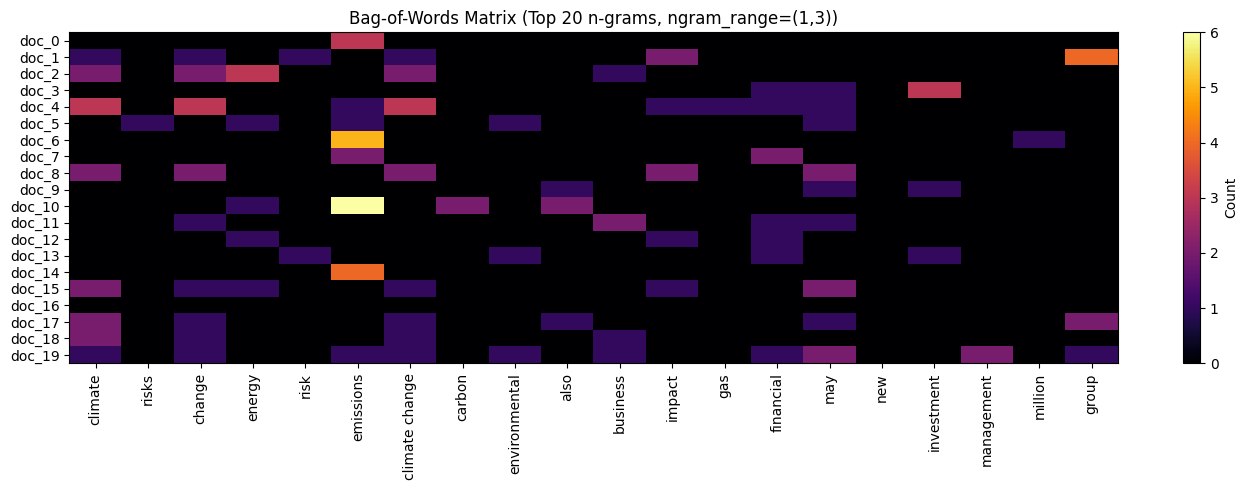

In [23]:
# top 20 most frequent ngrams
top_idx = counts.argsort()[::-1][:20]
top_terms = vocab[top_idx]

# lấy 10 document đầu tiên
n_docs = 20
bow_matrix = X_train_best[:n_docs, top_idx].toarray()

plt.figure(figsize=(14, 5))
plt.imshow(bow_matrix, aspect="auto", cmap="inferno")
plt.colorbar(label="Count")

plt.xticks(
    ticks=np.arange(len(top_terms)),
    labels=top_terms,
    rotation=90
)
plt.yticks(
    ticks=np.arange(n_docs),
    labels=[f"doc_{i}" for i in range(n_docs)]
)

plt.title("Bag-of-Words Matrix (Top 20 n-grams, ngram_range=(1,3))")
plt.tight_layout()
plt.show()


### Pretrained Word Embedding - Word2Vec

In [30]:
import numpy as np
import pandas as pd

from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler

# 1) Tokenize (keep simple, consistent with your cleaned_text)
train_tokens = [t.split() for t in X_train_text]
test_tokens  = [t.split() for t in X_test_text]


def avg_doc_vector(tokens, wv_model, dim):
    vecs = [wv_model[w] for w in tokens if w in wv_model]
    if len(vecs) == 0:
        return np.zeros(dim, dtype=np.float32)
    return np.mean(vecs, axis=0)

def build_doc_matrix(token_lists, wv_model, dim):
    return np.vstack([avg_doc_vector(toks, wv_model, dim) for toks in token_lists])

vector_sizes = [50, 100, 200, 300, 400, 500, 600, 700, 800, 1000]
results = []


for vs in vector_sizes:
    # 1) Train CBOW Word2Vec
    cbow_w2v = Word2Vec(
        sentences=train_tokens,
        vector_size=vs,
        window=10,
        min_count=2,
        workers=4,
        sg=0,
        epochs=80,
        seed=45
    )
    wv = cbow_w2v.wv
    dim = wv.vector_size  # == vs

    # 2) Build doc embeddings
    X_train_cbow = build_doc_matrix(train_tokens, wv, dim)
    X_test_cbow  = build_doc_matrix(test_tokens,  wv, dim)

    # 3) Scale (fit on train only)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train_cbow)
    X_test_s  = scaler.transform(X_test_cbow)

    # 4) Train LR on SCALED features (match predict)
    model = clone(lr_model)
    model.fit(X_train_s, y_train)

    # 5) Predict + evaluate using SAME model
    y_pred = model.predict(X_test_s)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")

    results.append({
        "vector_size": vs,
        "w2v_vocab_size": len(wv.key_to_index),
        "accuracy": acc,
        "f1_macro": f1m
    })

results_vs_df = pd.DataFrame(results).sort_values("f1_macro", ascending=False).reset_index(drop=True)
results_vs_df


,vector_size,w2v_vocab_size,accuracy,f1_macro
0,50,3511,0.781250,0.750712
1,500,3511,0.771875,0.733816
2,1000,3511,0.771875,0.733816
3,600,3511,0.768750,0.730909
4,400,3511,0.765625,0.724995
5,100,3511,0.759375,0.720758
6,800,3511,0.759375,0.720758
7,300,3511,0.753125,0.715030
8,200,3511,0.753125,0.711938
9,700,3511,0.746875,0.701296


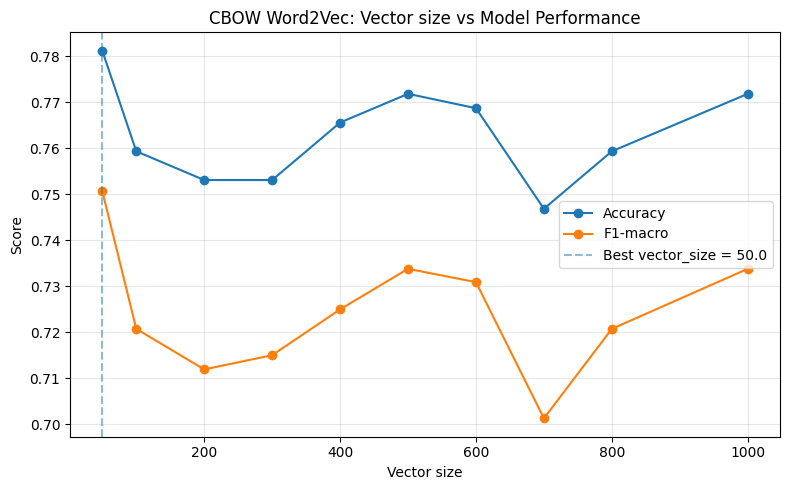

In [31]:
import matplotlib.pyplot as plt

# sort để đường nối đúng thứ tự
plot_df = results_vs_df.sort_values("vector_size")

# find best by F1
best_row = plot_df.loc[plot_df["f1_macro"].idxmax()]
best_vs = best_row["vector_size"]

plt.figure(figsize=(8, 5))

# plot both metrics
plt.plot(plot_df["vector_size"], plot_df["accuracy"],
         marker="o", label="Accuracy")

plt.plot(plot_df["vector_size"], plot_df["f1_macro"],
         marker="o", label="F1-macro")

# highlight best vector size
plt.axvline(best_vs, linestyle="--", alpha=0.5, label=f"Best vector_size = {best_vs}")

plt.xlabel("Vector size")
plt.ylabel("Score")
plt.title("CBOW Word2Vec: Vector size vs Model Performance")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**Observation:** The figure illustrates the impact of Word2Vec CBOW embedding dimensionality on classification performance. Both accuracy and F1-macro peak at a vector size of 50, indicating that smaller embeddings generalize better for this dataset. Increasing the vector size beyond this point does not consistently improve performance and may introduce noise, leading to diminishing returns or performance degradation. This suggests that overly large embeddings are unnecessary for this task.

### Method Comparison

In [33]:
print(results_vs_df)
print(results_df)

   vector_size  w2v_vocab_size  accuracy  f1_macro
0           50            3511  0.781250  0.750712
1          500            3511  0.771875  0.733816
2         1000            3511  0.771875  0.733816
3          600            3511  0.768750  0.730909
4          400            3511  0.765625  0.724995
5          100            3511  0.759375  0.720758
6          800            3511  0.759375  0.720758
7          300            3511  0.753125  0.715030
8          200            3511  0.753125  0.711938
9          700            3511  0.746875  0.701296
  ngram_range  vocab_size  X_train_shape  accuracy  f1_macro
0      (1, 3)       77135  (1000, 77135)  0.781250  0.734735
1      (1, 2)       39119  (1000, 39119)  0.768750  0.721333
2      (1, 1)        6424   (1000, 6424)  0.756250  0.708070
3      (2, 2)       32695  (1000, 32695)  0.756250  0.660408
4      (2, 3)       70711  (1000, 70711)  0.753125  0.633150
5      (3, 3)       38016  (1000, 38016)  0.700000  0.431111


**Conclusion:** While Bag-of-Words with ngram_range (1,3) provides competitive accuracy, CBOW Word2Vec embeddings achieve higher F1-macro with far fewer features. This indicates that dense semantic representations capture contextual information more effectively and generalize better across classes than high-dimensional sparse BoW features.